# Решение задачи сопоставления и поиска наиболее похожих товаров

**Дано:** два множества объектов: A и B. Каждый объект в множестве описывается безымянными признаками.

**Цель:** для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по заданной метрике.

**Задача:**
- разработать алгоритм, который для всех товаров измножества A предложит несколько вариантов наиболее похожих товаров из множества B;
- оценить качество алгоритма по метрике accuracy@5;
- деплой: разработать REST API сервис, который по предложенным данным будем предлагать несколько похожих товаров.


## Загрузка и ознакомление с данными

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats as st
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import recall_score, make_scorer, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
import time
import phik
import faiss
from tqdm.notebook import tqdm
import annoy
from annoy import AnnoyIndex
import hnswlib
import lightgbm as lgb
import xgboost as xgb
import joblib
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

RANDOM_STATE = 73

d:\Stadies IT\Project\3. Masterskay\Masterskay\masterskay_2_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_base_res = pd.read_csv('./data/base.csv', index_col=0)
df_train_res = pd.read_csv('./data/train.csv', index_col=0)
df_validation_res = pd.read_csv('./data/validation.csv', index_col=0)
df_validation_answer_res = pd.read_csv('./data/validation_answer.csv', index_col=0)

print('Вывод первых пяти строк для таблицы \'base.csv\'')
display(df_base_res.head())

print('Вывод первых пяти строк для таблицы \'train.csv\'')
display(df_train_res.head())

print('Вывод первых пяти строк для таблицы \'validation.csv\'')
display(df_validation_res.head())

print('Вывод первых пяти строк для таблицы \'validation_answer.csv\'')
display(df_validation_answer_res.head())

Вывод первых пяти строк для таблицы 'base.csv'


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

Вывод первых пяти строк для таблицы 'train.csv'


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

Вывод первых пяти строк для таблицы 'validation.csv'


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

Вывод первых пяти строк для таблицы 'validation_answer.csv'


,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [3]:
print('Вывод общей информации для таблицы \'base.csv\'', '\n')
df_base_res.info()

print('\nВывод общей информации для таблицы \'train.csv\'', '\n')
df_train_res.info()

print('\nВывод общей информации для таблицы \'validation.csv\'', '\n')
df_validation_res.info()

print('\nВывод общей информации для таблицы \'validation_answer.csv\'')
df_validation_answer_res.info()

Вывод общей информации для таблицы 'base.csv' 

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      fl

In [4]:
passes = df_train_res.isna().sum().sum() + \
         df_base_res.isna().sum().sum() + \
         df_validation_res.isna().sum().sum() + \
         df_validation_answer_res.isna().sum().sum()

print('Общее количество пропусков в исследуемыз данных:', passes)

Общее количество пропусков в исследуемыз данных: 0


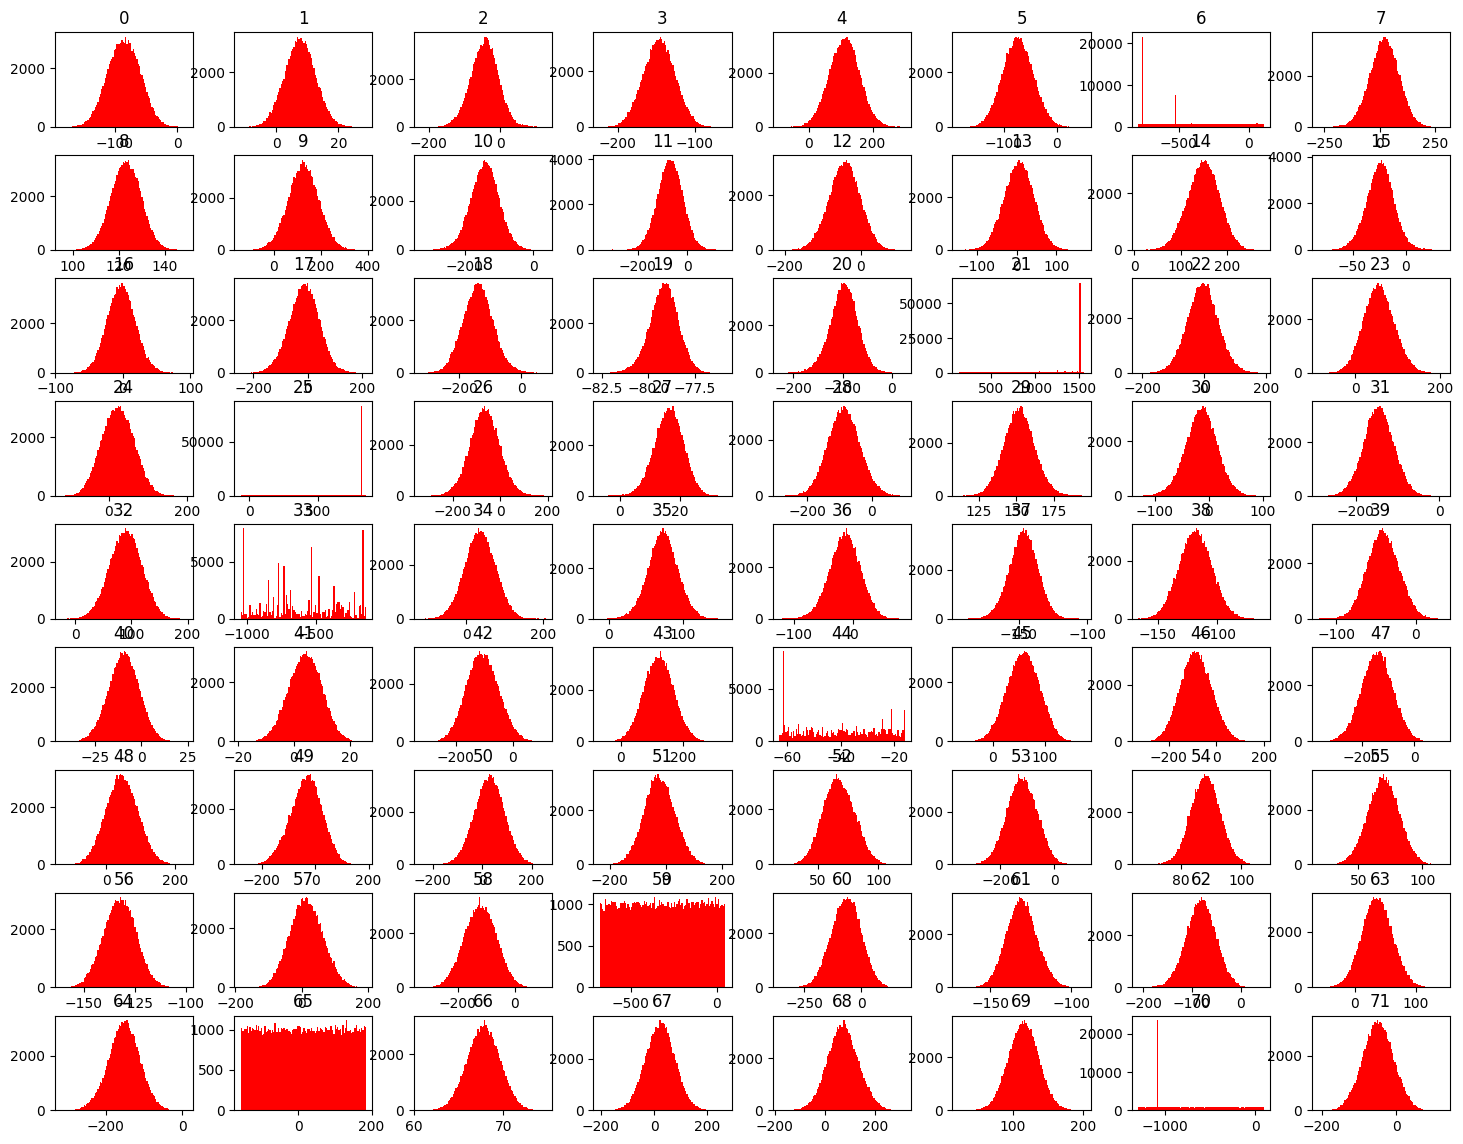

In [5]:
df_train_res.hist(figsize=(18, 14), bins=100, grid=False, color='red');

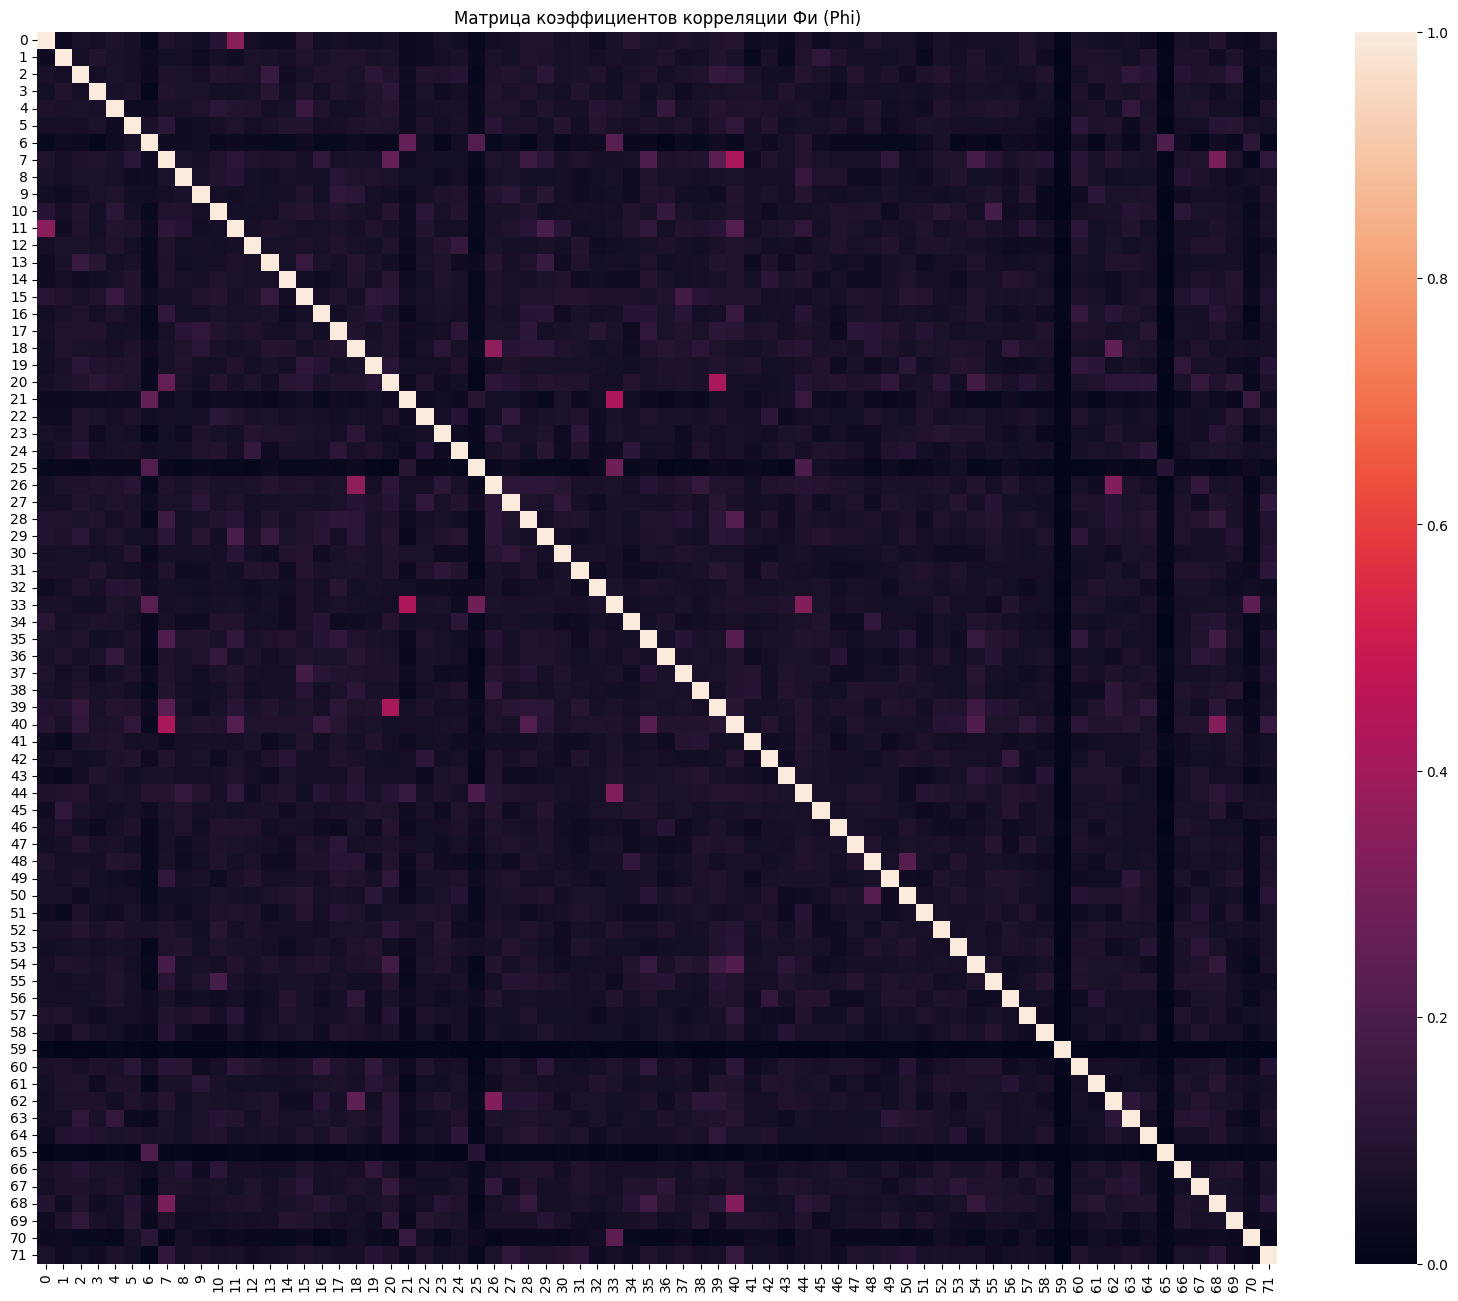

In [6]:
f, ax = plt.subplots(figsize=(20, 16))
phik_matrix = df_train_res.drop('Target', axis=1).phik_matrix(interval_cols=df_train_res.drop('Target', axis=1).columns)
sns.heatmap(phik_matrix, vmin=0, vmax=1, square=False, annot=False, fmt='.1f')
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

## Предварительная обработка данных

In [7]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

df_base_res = optimize_memory_usage(df_base_res)
df_train_res = optimize_memory_usage(df_train_res)
df_validation_res = optimize_memory_usage(df_validation_res)
df_validation_answer_res = optimize_memory_usage(df_validation_answer_res)

Размер использования памяти: до 1625.25 Mb - после 823.75 Mb (49.3%)
Размер использования памяти: до 56.46 Mb - после 28.99 Mb (48.6%)
Размер использования памяти: до 55.69 Mb - после 28.23 Mb (49.3%)
Размер использования памяти: до  1.53 Mb - после  1.53 Mb (0.0%)


### Вывод

Данные в основном представлены непрерывными числовыми значениями, основная их доля очевидно имеет нормальное распределение. Те данные, которые явно не характеризуются нормальным распределением, будут вносить лишний шум в результаты метчинга. Пропусков не обнаружено, сильных корреляций и зависимостей так же не выявлено.

In [8]:
# Отбрасываем признаки по результатам исследования качества метчинга
features_drop = ['21','25','33','44','59','65','6','44']

df_base_res = df_base_res.drop(features_drop, axis=1)
df_train_res = df_train_res.drop(features_drop, axis=1)
df_validation_res = df_validation_res.drop(features_drop, axis=1)

## Разведочный анализ данных

In [9]:
# Фильтруем признаки, отличающиеся со значимостью более 0,0001
TUNE_SIMILARITIES = False

if TUNE_SIMILARITIES == True:
    E_As = np.sqrt(6 / len(df_base_res))
    E_Ex = 2 * E_As
    drop_list = [] # Список признаков для фильтрации
    for feat in df_base_res.columns:
        # Считаем сумму модулей значений соотношения коэффициентов асимметрии и эксцесса к их ошибкам признака feat
        feat_as_ex_sum = abs(df_base_res[feat].skew() / E_As) + abs(df_base_res[feat].kurt() / E_Ex)
        for other_feat in df_base_res.columns:
            if other_feat == feat:
                pass
            else:
                stat, p_value = st.ttest_ind(df_base_res[feat], df_base_res[other_feat], equal_var=False)
                # Считаем сумму модулей значений соотношения коэффициентов асимметрии и эксцесса к их ошибкам признака other_feat
                other_feat_as_ex_sum = abs(df_base_res[other_feat].skew() / E_As) + abs(df_base_res[other_feat].kurt() / E_Ex)
                # Добавляем в список фильтрации признак с наибольшем отличием от нормального распределения
                if (p_value > 0.0001) and (feat_as_ex_sum > other_feat_as_ex_sum) and (feat not in drop_list):
                    drop_list.append(feat)
                elif (p_value > 0.0001) and (feat_as_ex_sum < other_feat_as_ex_sum) and (other_feat not in drop_list):
                    drop_list.append(other_feat)
    print(f'Список признаков для фильтрации: {drop_list}')
else:
    drop_list = ['3', '50']
    print(f'Список признаков для фильтрации: {drop_list}')

df_base = df_base_res.drop(drop_list, axis=1)
df_train = df_train_res.drop(drop_list, axis=1)
df_validation = df_validation_res.drop(drop_list, axis=1)

# Отфильтровываем дубликаты
print('Количество дубликатов в датафрейме df_base:', df_base.duplicated().sum())
df_base.dropna(inplace=True)
print('Количество дубликатов в датафрейме df_train:', df_train.duplicated().sum())
df_train.dropna(inplace=True)

Список признаков для фильтрации: ['3', '50']
Количество дубликатов в датафрейме df_base: 274445
Количество дубликатов в датафрейме df_train: 2126


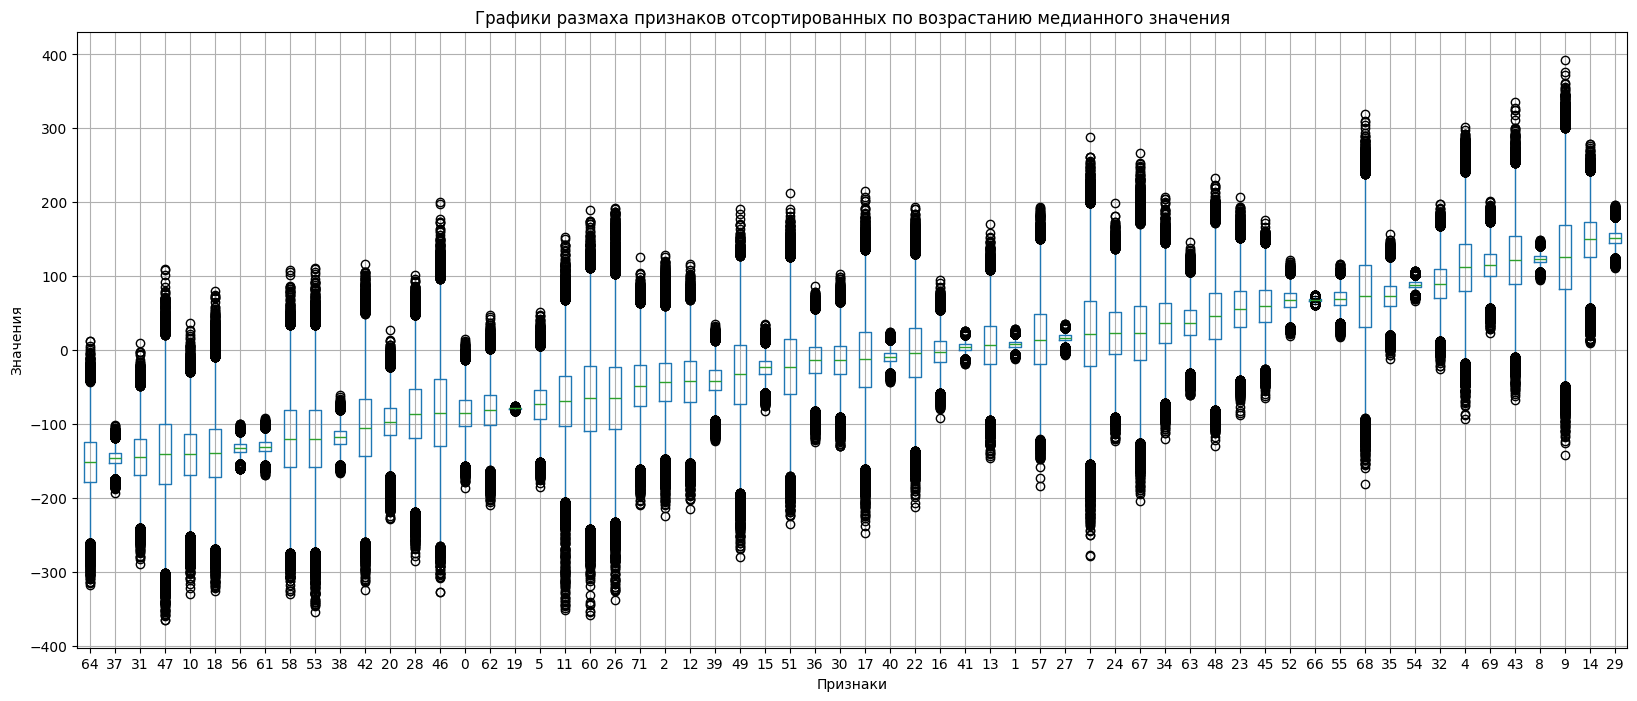

In [10]:
# Рассмотрим медианные значения и стандартное отклонение исследуемых признаков
medians = df_train.drop(['Target','70'], axis=1).median()
df_sorted = df_train[medians.sort_values().index] # Сортируем значения медиан в возрастающем порядке

# Построение графиков для каждого признака в отсортированном порядке
fig, ax = plt.subplots(figsize=(20, 8))
df_sorted.boxplot(ax=ax)
plt.xlabel('Признаки')
plt.ylabel('Значения')
plt.title('Графики размаха признаков отсортированных по возрастанию медианного значения')
plt.show()

### Вывод

Найдены две пары признаков, отличия которых не значимы на уровне 0,0001, из них отфильтрованы признаки '3', '50', которые характеризуются распределением, в наибольшей степени отличающимся от нормального.
Обнаружены и удалены дубликаты в количестве 9,4% для df_base и 2% для df_train.

In [11]:
# Стандартизация признаков наиболее подходящей моделью
scaler = StandardScaler()
df_base = scaler.fit_transform(df_base_res)
#joblib.dump(scaler, 'standard_scaler.pkl') # Сохранение модели в файл
df_train = scaler.transform(df_train_res.drop('Target', axis=1))
df_validation = scaler.transform(df_validation_res)

df_base = pd.DataFrame(df_base, columns=df_base_res.columns, index=df_base_res.index)
df_train = pd.DataFrame(df_train, columns=df_base_res.columns, index=df_train_res.index)
df_validation = pd.DataFrame(df_validation, columns=df_validation_res.columns, index=df_validation_res.index)

df_train['Target'] = df_train_res['Target']

X = np.ascontiguousarray(np.array(df_train.drop('Target', axis=1)))
Y = np.ascontiguousarray(np.array(df_train['Target']))

X_test = np.ascontiguousarray(np.array(df_validation))
Y_test = np.ascontiguousarray(np.array(df_validation_answer_res))

## Выбор подходящих ML моделей

### Поиск ближайших соседей: **FAISS**

In [12]:
# Подбор оптимальных гиперпараметров для получения индексов FAISS
TUNE_INDEX = False

if TUNE_INDEX == True:
    dims = df_base.shape[1]
    n_cells = 20

    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFPQ(quantizer, dims, n_cells, 8, 8)

    start_time = time.time() # Считаем время создания индексов
    idx_l2.train(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
    print(f'Время создания индексов: {np.round((time.time() - start_time) / 60, 2)} мин')

    start = time.time() # Считаем время поиска индексов
    r, idx = idx_l2.search(np.ascontiguousarray(X.values).astype('float32'), 5)
    print('Время поиска:', np.round((time.time() - start) / 60, 2), 'мин')

    acc = sum(int(target in [base_index[r] for r in el]) for target, el in zip(Y.values.tolist(), idx.tolist()))
    accuracy = np.round(100 * acc / len(idx), 2)
    print(f'Значение целевой метрики: {accuracy} %')

- Используем faiss.IndexIVFFlat(quantizer, dims, n_cells=20), accuracy@5 = 69,2%, время поиска индексов = 39,6 мин
- Используем faiss.IndexIVFFlat(quantizer, dims, n_cells=20), accuracy@5 = 60,3%, время поиска индексов = 1,8 мин
- Используем faiss.IndexIVFPQ(quantizer, dims, n_cells=1, 8, 8), accuracy@5 = 64.5%, время поиска индексов = 5.0 мин
- Используем faiss.IndexIVFPQ(quantizer, dims, n_cells=20, 8, 8), accuracy@5 = 57.9%, время поиска индексов = 0.7 мин

In [13]:
faiss_res = {
    'n_cells':           [1, 4, 5, 6, 10, 15, 20, 25, 30],
    '100-accuracy@5':    [30.8, 36.2, 36, 37.8, 38.6, 39.2, 39.6, 39.7, 40],
    'index_search_time': [39.6, 10.4, 7.5, 7.5, 4.2, 2.8, 2.1, 1.7, 1.4]
}
faiss_res = pd.DataFrame(faiss_res)

mms = MinMaxScaler()
faiss_res_mms = pd.DataFrame(mms.fit_transform(faiss_res), columns=faiss_res.columns)

fig = go.Figure()
fig.add_trace(go.Scatter(x=faiss_res.n_cells, y=faiss_res_mms['100-accuracy@5'], mode='lines', name='100-accuracy@5'))
fig.add_trace(go.Scatter(x=faiss_res.n_cells, y=faiss_res_mms['index_search_time'], mode='lines', name='index_search_time'))
fig.update_layout(
    xaxis_title='Количество ячеек n_cells', 
    yaxis_title='Значение 100-accuracy@5 и index_search_time', 
    title=f'Изменение наблюдаемых метрик при увеличении количества ячеек n_cells')
fig.show()

Наиболее оптимальное количество n_cells будет находится в районе 5 шт, при этом время поиска индексов составит 10 мин. Наиболее приемлемым значением кажется 15-20, дающее более-менее быстрый поиск по индексу. Наиболее подходящим индексным методом является IndexIVFPQ, который даёт небольшое снижение показателя целевой метрики, но в разы повышает скорость поиска индексов. Он эффективно решает проблему поиска ближайших соседей путем разделения пространства на разделы и квантизации данных в этих разделах с использованием кодовых книг, в нашем конкретном случае равное 8.

### Поиск ближайших соседей: **Annoy**

In [14]:
# Подбор оптимальных гиперпараметров для получения индексов Annoy
TUNE_INDEX = False

if TUNE_INDEX == True:
    dims = df_base.shape[1]
    n_cells = 55
    distance = 'euclidean'

    start_time = time.time() # Считаем время создания индексов
    idx_annoy = AnnoyIndex(dims, distance)
    data = np.ascontiguousarray(df_base.values)

    for i in range(data.shape[0]): # Добавление данных в индекс
        idx_annoy.add_item(i, data[i])

    idx_annoy.build(n_cells) # Построение индекса
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())} # Создание базового индекса
    print(f'Время создания индексов: {np.round((time.time() - start_time) / 60, 2)} мин')

    #idx_annoy.save('idx_annoy_01.bin') # Сохраняем индекс в файл
    #idx_annoy.load('idx_annoy_01.bin') # Загружаем индекс из файла

    start_time = time.time() # Считаем время поиска индексов
    idx = [idx_annoy.get_nns_by_vector(x, 5) for x in X.values]
    print(f'Время поиска: {np.round((time.time() - start_time) / 60, 2)} мин')

    acc = sum(int(target in [base_index[r] for r in el]) for target, el in zip(Y.values.tolist(), idx))
    accuracy = np.round(100 * acc / len(idx), 2)
    print(f'Значение целевой метрики: {accuracy} %')

else:
    print('Время создания индексов: 3.42 мин\nВремя поиска: 0.3 мин\nЗначение целевой метрики: 66.72 %')

Время создания индексов: 3.42 мин
Время поиска: 0.3 мин
Значение целевой метрики: 66.72 %


In [15]:
faiss_res = {
    'n_cells':           [20, 50, 55, 60, 80, 110],
    '100-accuracy@5':    [38.9, 33.7, 33.3, 32.9, 32, 31],
    'index_search_time': [0.18, 0.3, 0.32, 0.35, 0.43, 0.55]
}
faiss_res = pd.DataFrame(faiss_res)

mms = MinMaxScaler()
faiss_res_mms = pd.DataFrame(mms.fit_transform(faiss_res), columns=faiss_res.columns)

fig = go.Figure()
fig.add_trace(go.Scatter(x=faiss_res.n_cells, y=faiss_res_mms['100-accuracy@5'], mode='lines', name='100-accuracy@5'))
fig.add_trace(go.Scatter(x=faiss_res.n_cells, y=faiss_res_mms['index_search_time'], mode='lines', name='index_search_time'))
fig.update_layout(
    xaxis_title='Количество ячеек n_cells', 
    yaxis_title='Значение 100-accuracy@5 и index_search_time', 
    title=f'Изменение наблюдаемых метрик при увеличении количества ячеек n_cells')
fig.show()

Наиболее оптимальное количество n_cells будет находится в районе 50-60 шт, при этом время поиска индексов составит 0.3 мин, значение целевой метрики 66.7%. Annoy предоставляет приемлемое значение целевой метрики при хорошей скорости работы алгоритма и небольшом потреблении ресурсов, при этом основная доля времени уходит на построение списка индексов, а не на их поиск.

### Поиск ближайших соседей: **HNSW**

In [16]:
# Подбор оптимальных гиперпараметров Оптюной для получения индексов HNSW
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS == True:
    def objective(trial: optuna.Trial):
        M = trial.suggest_int('M', 16, 512, step=4)
        ef_construction = trial.suggest_int('ef_construction', 20, 300, step=5)

        p = hnswlib.Index(space='cosine', dim=df_base.shape[1])
        p.init_index(max_elements=df_base.shape[0], ef_construction=ef_construction, M=M)
        p.add_items(df_base.values)
        base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
        p.set_ef(50)
        
        start = time.time()
        labels, distances = p.knn_query(X.values, k=5)
        acc = sum(int(target in [base_index[r] for r in el]) for target, el in zip(Y.values.tolist(), labels.tolist()))
        accuracy = np.round(100 * acc / len(labels), 2)

        if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        
        trial.set_user_attr('duration_of_operation', np.round((time.time() - start) / 60, 2))

        if np.round((time.time() - start) / 60, 2) > 0.5:
             return 0
        else:
             return accuracy

    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        trial.user_attrs['duration_of_operation']
        score = trial.user_attrs['duration_of_operation']
        print(f'Trial {trial.number}: Duration_of_operation={score}')

    study = optuna.create_study(study_name='HNSW', 
                                direction='maximize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                pruner=SuccessiveHalvingPruner(),
                                storage='sqlite:///data/my_study_HNSW.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, callbacks=[custom_callback])

else:
    print('Trial 4 finished with value: 70.48 and parameters: { M: 90, ef_construction: 248 }. Duration_of_operation=0.08')

Trial 4 finished with value: 70.48 and parameters: { M: 90, ef_construction: 248 }. Duration_of_operation=0.08


In [17]:
# Подбор оптимальных гиперпараметров для получения индексов HNSW
TUNE_INDEX = False

if TUNE_INDEX == True:
    dims = df_base.shape[1]
    space = 'cosine'
    ef_construction = 248
    m = 90
    optimizer = 600

    start_time = time.time() # Считаем время создания индексов
    idx_hnsw = hnswlib.Index(space=space, dim=dims)
    idx_hnsw.init_index(max_elements=df_base.shape[0], ef_construction=ef_construction, M=m)
    idx_hnsw.add_items(df_base.values) # Добавление векторов в индекс
    idx_hnsw.set_ef(optimizer)
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
    print(f'Время создания индексов: {np.round((time.time() - start_time) / 60, 2)} мин')

    #idx_hnsw.save_index('idx_hnsw.bin') # Сохраняем индекс в файл
    #idx_hnsw.load_index('idx_hnsw.bin') # Загружаем индекс из файла

    start = time.time() # Считаем время поиска индексов
    labels, distances = idx_hnsw.knn_query(X.values, k=5)
    print('Время поиска:', np.round((time.time() - start) / 60, 2), 'мин')

    acc = sum(int(target in [base_index[r] for r in el]) for target, el in zip(Y.values.tolist(), labels.tolist()))
    accuracy = np.round(100 * acc / len(labels), 2)
    print(f'Значение целевой метрики: {accuracy} %')

else:
    print('Время создания индексов: 11 мин\nВремя поиска: 0.52 мин\nЗначение целевой метрики: 71.35 %')

Время создания индексов: 11 мин
Время поиска: 0.52 мин
Значение целевой метрики: 71.35 %


Очень мощный алгоритм, дающий очень высокую скорость поиска индексов и высокое качество поиска, при этом имеет высокие требования к оперативной памяти. Поскольку для данной задачи проблематика использования оперативной памяти была определена как незначительная, был выбрана именно эта библиотека. Количество используемой памяти и, следовательно, размер готового списка индексов напрямую зависит от количества связей (параметр 'm') но сильно в меньшей степени от слоёв (ef_construction), при этом количество слоем повышает время поиска индекса и не так хорошо улучшает точность модели, по сравнению с количеством связей. В связи с этим было экспериментально выбрано m=90, и ef_construction = 248 дающей отличный показатель точности (70.48%), отличную скорость поиска (0.08 мин) и при этом модель щадяще используем память и размер сформированных индексов менее 3Gb. Поскольку скорость поиска излишне высокая, можно поднять параметр оптимизации поиска (optimizer=600), при этом скорость поиска вырастет в 6,5 раз до 0.52 мин, а точность на 0,87% до 71.35%, достоинство данного параметра состоит в том, что его можно изменять в зависимости от нагрузка на сервис, без изменения сгенерированной модели. Скорость поиска 100К индексов (Y) зависит линейно от значения параметра optimizer (X) приблизительно по уравнению: Y = 0.0008 * X + 0.05.

### Вывод
- Библиотека FAISS (Facebook AI Similarity Search) показывает наиболее приемлемые значением в диапазоне 15-20, дающее более-менее быстрый поиск по индексу. Наиболее подходящим индексным методом является IndexIVFPQ, который даёт небольшое снижение показателя целевой метрики, но в разы повышает скорость поиска индексов. Он эффективно решает проблему поиска ближайших соседей путем разделения пространства на разделы и квантизации данных в этих разделах с использованием кодовых книг, в нашем конкретном случае равное 8.
- Annoy (Approximate Nearest Neighbors Oh Yeah) показывает наиболее оптимальные результаты при количестве n_cells районе 50-60 шт, при этом время поиска индексов составит 0.3 мин, значение целевой метрики 66.7%. Annoy предоставляет приемлемое значение целевой метрики при хорошей скорости работы алгоритма и небольшом потреблении ресурсов, при этом основная доля времени уходит на построение списка индексов, а не на их поиск.
- HNSW (Hierarchical Navigable Small World) oчень мощный алгоритм, дающий очень высокую скорость поиска индексов и высокое качество поиска, при этом имеет высокие требования к оперативной памяти. Поскольку для данной задачи проблематика использования оперативной памяти была определена как незначительная, был выбрана именно эта библиотека. Количество используемой памяти и, следовательно, размер готового списка индексов напрямую зависит от количества связей (параметр 'm') но сильно в меньшей степени от слоёв (ef_construction), при этом количество слоем повышает время поиска индекса и не так хорошо улучшает точность модели, по сравнению с количеством связей. В связи с этим было экспериментально выбрано m = 90, и ef_construction = 248 дающей отличный показатель точности (70.48%), отличную скорость поиска (0.08 мин) и при этом модель щадяще используем память и размер сформированных индексов менее 3Gb. Поскольку скорость поиска излишне высокая, можно поднять параметр оптимизации поиска (optimizer=600), при этом скорость поиска вырастет в 6,5 раз до 0.52 мин, а точность на 0,87% до 71.35%, достоинство данного параметра состоит в том, что его можно изменять в зависимости от нагрузка на сервис, без изменения сгенерированной модели. Скорость поиска 100К индексов (Y) зависит линейно от значения параметра optimizer (X) приблизительно по уравнению: Y = 0.0008 * X + 0.05.

## Оптимизация предсказаний выбранной модели

Наиболее оптимальной библиотекой для решения поставленой задачи выбрана HNSW с параметрами { M: 90, ef_construction: 248, optimizer: 600}

In [18]:
# Построим индексы модели с предсказанными векторами
base_index = {k: v for k, v in enumerate(df_base.index)}
idx_hnsw = hnswlib.Index(space='cosine', dim=df_base.shape[1])
idx_hnsw.load_index('idx_hnsw.bin') # Загружаем индекс из файла
idx_hnsw.set_ef(600)

# Сохранение индексов
#joblib.dump(idx_hnsw, 'idx_hnsw.pkl')
#joblib.dump(base_index, 'base_index.pkl')

labels, distances = idx_hnsw.knn_query(X, k=200)

# Считаем метрику для первых 5 значений
acc = sum(int(target in [base_index[x] for x in el[:5]]) for target, el in zip(Y, labels))
print(f'Значение целевой метрики: {np.round(100 * acc / len(labels), 2)} %')

Значение целевой метрики: 71.38 %


- Значение целевой метрики для 5 значений: 71.35 %
- Значение целевой метрики для 10 значений: 74.21 %
- Значение целевой метрики ля 200 значений: 82.59 %

Доля правильных ответов при увеличении количества рассматриваемых наиболее вероятных индексов, уменьшается экспоненциально, и нет большого смысла рассматривать сильно большую выборку, это не даст большого прироста точности, при этом сильно увеличит время поиска индексов.

Подберём модель бинарной классификации и разделим исследуемые данные на те, которые отметчились и нет.

In [19]:
# Подбор оптимальной модели классификации
TUNE_MODELS = False

mlr = LogisticRegression(random_state=RANDOM_STATE)
mdtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
mrfc = RandomForestClassifier(random_state=RANDOM_STATE)
mcbc = CatBoostClassifier(random_state=RANDOM_STATE, verbose = False)
mknn = KNeighborsClassifier(n_neighbors=5)
mxgb = xgb.XGBClassifier(random_state=RANDOM_STATE, verbosity=0)
mlgb = lgb.LGBMClassifier(objective='binary', random_state=RANDOM_STATE, verbosity=-1)

Y_for_5 = np.array([int(target in [base_index[x] for x in el[:5]]) for target, el in zip(Y, labels)])
Y_for_5 = np.ascontiguousarray(Y_for_5)

if TUNE_MODELS == True:
    for m in [mlr,mdtc,mrfc,mcbc,mknn,mxgb,mlgb]:
        start = time.time()
        scores = cross_val_score(m, X, Y_for_5, cv=5, scoring='recall')
        print(f'{m}: recall: {np.mean(scores).round(3)}, time: {np.round((time.time() - start) / 4, 1)} c')

- LogisticRegression: recall: 0.958, time: 0.2 c
- DecisionTreeClassifier: recall: 0.747, time: 25.3 с
- RandomForestClassifier: recall: 0.982, time: 231.0 c
- CatBoostClassifier: recall: 0.956, time: 23.7 c - ниболее оптимальная модель
- KNeighborsClassifier: recall: 0.754, time: 5.0 c
- XGBClassifier: recall: 0.926, time: 1.9 c
- LGBMClassifier: recall: 0.974, time: 1.6 c

In [ ]:
# Подбор оптимальных гиперпараметров бинарной классификации
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS == True:
    def objective(trial: optuna.Trial):
        params = {
            'iterations': trial.suggest_int('iterations', 1000, 5000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.0001, 1, step=0.001),
            'depth': trial.suggest_int('depth', 2, 12, step=1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.001, 100, log=True),
            'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian']),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 2, step=0.01),
            'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
            'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree']),
            }
        mcbc = CatBoostClassifier(**params, random_state=RANDOM_STATE, verbose=False, task_type='GPU')
        scores = cross_val_score(mcbc, X, Y_for_5, cv=5, scoring='recall')

        return scores.mean()

    study = optuna.create_study(study_name='CatBoostClassifier', 
                                direction='maximize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                storage='sqlite:///my_study_CatBoostClassifier.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=500, timeout=None, n_jobs=1)

In [21]:
mcbc = CatBoostClassifier(
    random_state=RANDOM_STATE,
    iterations=4600,
    learning_rate=0.1041,
    depth=12,
    l2_leaf_reg=0.0016486815857467566,
    bootstrap_type='Bayesian',
    bagging_temperature=0.06,
    od_type='IncToDec',
    leaf_estimation_method='Newton',
    grow_policy='SymmetricTree',
    verbose=False
    )
#mcbc.fit(X, Y_for_5)
#mcbc.save_model('mcbc_model.cbm')
mcbc.load_model('mcbc_model.cbm')

pred_pos = mcbc.predict(X)
print(f'Процент правильно предсказанных положительных ответов {np.round(sum((Y_for_5 == 1)&(pred_pos == 1)) * 100 / len(Y_for_5),2)} %')
print(f'Значение recall для положительного класса: {recall_score(Y_for_5, pred_pos)}')

Процент правильно предсказанных положительных ответов 71.36 %
Значение recall для положительного класса: 0.9996777854050798


Подобрав модель бинарной классификации, мы смогли хорошо разделить данные которые отметчились, согласна целевой метрики, доля которых составляет 71,36%. Таким образом мы можем с высокой долей вероятности определить те данные, для которых мы найдём положительный исход в первых пяти предсказанных вариантах продукта.

Если модель машинного обучения классифицирует объекты всегда согласна значениям переданных признаков, то эксперт может руководствоваться и иными свойствами, и признаками, данных о которых мы лишены. Исходя из предположения, что это обстоятельство может так или иначе сместить положение объекта в иерархии предложенных расстояний, постоим регрессионную модель, которая б определяла наиболее вероятный индекс положения прогнозируемого объекта (или смещения).

In [22]:
# Считаем индекс положительного таргента в списке метчинга
order_list = []
for tar, el in zip(Y, labels):
    if (tar in [base_index[x] for x in el]):
        order_list.append([base_index[x] for x in el].index(tar))
    else:
        order_list.append(None)

df_train['order_list'] = order_list
X_ord = np.array(df_train[(df_train['order_list'] > 4)&(~df_train['order_list'].isna())].drop(['Target','order_list'], axis=1))
Y_ord = np.array(df_train[(df_train['order_list'] > 4)&(~df_train['order_list'].isna())]['order_list'])

X_ord = np.ascontiguousarray(X_ord)
Y_ord = np.ascontiguousarray(Y_ord)

In [23]:
# Подбор оптимальной модели регрессии
TUNE_MODELS = False

mlr = LinearRegression()
ml = Lasso(random_state=RANDOM_STATE, precompute=True)
mr = Ridge(random_state=RANDOM_STATE)
men = ElasticNet(random_state=RANDOM_STATE)
mdtr = DecisionTreeRegressor(random_state=RANDOM_STATE)
mcbr = CatBoostRegressor(verbose=False, random_state=RANDOM_STATE)
mlgb = lgb.LGBMRegressor(random_state=RANDOM_STATE, verbosity=-1)
mxgb = xgb.XGBRegressor(random_state=RANDOM_STATE)
mknr = KNeighborsRegressor()
mgbr = GradientBoostingRegressor(random_state=RANDOM_STATE)

if TUNE_MODELS == True:
    for m in [mlr,ml,mr,men,mdtr,mcbr,mlgb,mxgb,mknr,mgbr]:
        start = time.time()
        scores = cross_val_score(m, X_ord, Y_ord, cv=3, scoring='r2')
        print(f'{m}: r2: {np.mean(scores).round(5)}, time: {np.round((time.time() - start) / 4, 1)} c')

- LinearRegression: r2: 0.00438, time: 0.0 c
- Lasso: r2: 0.004, time: 0.0 c
- Ridge: r2: 0.00438, time: 0.0 c
- ElasticNet: r2: 0.00592, time: 0.0 c
- DecisionTreeRegressor: r2: -0.92618, time: 2.4 c
- LGBMRegressor: r2: 0.01042, time: 0.2 c
- XGBRegressor: r2: -0.10063, time: 0.7 c
- KNeighborsRegressor: r2: -0.14944, time: 0.1 c
- GradientBoostingRegressor: r2: 0.00766, time: 32.8 c
- CatBoostRegressor: r2: 0.02125, time: 6.3 c

In [24]:
# Подбор оптимальных гиперпараметров
TUNE_HYPERPARAMETERS = False

if TUNE_HYPERPARAMETERS == True:
    def objective(trial: optuna.Trial):
        params = {
            'iterations': trial.suggest_int('iterations', 500, 10000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=0.01),
            'depth': trial.suggest_int('depth', 1, 12),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 100.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 5, step=0.01),
            }
        mcbr = CatBoostRegressor(**params, random_state=RANDOM_STATE, verbose=False, task_type='GPU')
        scores = cross_val_score(estimator=mcbr, X=X_ord, y=Y_ord, scoring=make_scorer(mean_absolute_error), cv=5)   

        ass = []
        for pos, el, tar, x_val in zip(pred_pos, labels, Y, X):
            if pos == 1:
                pass
            else:
                ind = int(np.round(mcbr.predict(x_val),0))
                ass.append(int(tar in [base_index[x] for x in el[ind-3:ind+2]]))

        trial.set_user_attr('sum_ass', sum(ass))

        return scores.mean()
    
    def custom_callback(study: optuna.Study, trial: optuna.Trial):
        trial.user_attrs['sum_ass']
        score = trial.user_attrs['sum_ass']
        print(f'Trial {trial.number}: sum_ass={score}')

    study = optuna.create_study(study_name='CatBoostRegressor', 
                                direction='minimize', 
                                sampler=TPESampler(seed=RANDOM_STATE),
                                storage='sqlite:///data/my_study_CatBoostRegressor.db',
                                load_if_exists=True
                                )
    study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, callbacks=[custom_callback])

- `Trial 11 finished with value: 37.10854400599686 and parameters: {'iterations': 2800, 'learning_rate': 0.01, 'depth': 12, 'l2_leaf_reg': 65.03663536941748, 'bagging_temperature': 2.94}. sum_ass=390`
- `Trial 37 finished with value: 37.229157466851106 and parameters: {'iterations': 8900, 'learning_rate': 0.47, 'depth': 12, 'l2_leaf_reg': 0.15222584079884435, 'bagging_temperature': 4.05}. sum_ass=3761`

In [25]:
# Обучение модели
mcbr = CatBoostRegressor(
    iterations=2800,
    learning_rate=0.01,
    depth=12,
    l2_leaf_reg=65.03663536941748,
    bagging_temperature=2.94,
    random_state=RANDOM_STATE,
    verbose=False, 
    task_type='GPU'
    )
#mcbr.fit(X_ord, Y_ord)
#mcbr.save_model('mcbr_model.cbm')
mcbr.load_model('mcbr_model.cbm')

pred_ord = mcbr.predict(X_ord)
print(f'Значение mae: {mean_absolute_error(Y_ord, pred_ord)}')

Значение mae: 32.55497055783316


In [26]:
# Предсказание с учётом регрессионной модели
start = time.time() # Считаем время предсказания
mcbc_val = mcbc.predict(X)
labels, distances = idx_hnsw.knn_query(X, k=200)

aсс = []
for pos, el, tar, x_val in zip(mcbc_val, labels, Y, X):
    if pos == 1:
        aсс.append(int(tar in [base_index[x] for x in el[:5]]))
    else:
        ind = int(np.round(mcbr.predict(x_val),0))
        aсс.append(int(tar in [base_index[x] for x in el[ind-3:ind+2]]))
print(f'Время предсказание: {np.round((time.time() - start) / 60, 2)} мин')
print(f'Значение целевой метрики: {np.round(100 * sum(aсс) / len(labels), 2)} %')

Время предсказание: 1.24 мин
Значение целевой метрики: 71.75 %


In [27]:
# Предсказание с учётом константы
start = time.time() # Считаем время предсказания
mcbc_val = mcbc.predict(X)
labels, distances = idx_hnsw.knn_query(X, k=200)

aсс = []
for pos, el, tar, x_val in zip(mcbc_val, labels, Y, X):
    if pos == 1:
        aсс.append(int(tar in [base_index[x] for x in el[:5]]))
    else:
        ind = 8
        aсс.append(int(tar in [base_index[x] for x in el[ind-3:ind+2]]))
print(f'Время предсказание: {np.round((time.time() - start) / 60, 2)} мин')
print(f'Значение целевой метрики: {np.round(100 * sum(aсс) / len(labels), 2)} %')

Время предсказание: 0.6 мин
Значение целевой метрики: 74.19 %


Полученное значение mae на кросвалидации значительно отличается от mae модели самой на себя, что свидетельствует о переобучении и малой предсказательной пригодности, созданной ML. Вероятно нужно провести дополнительную обработку признакового пространства и поэкспериментировать с различными синтетическими признаками для поиска зависимостей и улучшения предсказательной силы. Использование значений с высокими величинами sum_ass приводит к значительно большей переобучености. Можно отметить, что чем меньшее значение mae мы получаем, тем меньше мы обнаруживаем положительных совпадений accuracy@5.

Значение целевой метрики при использовании регрессионной модели (71.75 %) значительно отличаются от использования константы (случая, когда мы берём 5 значений с 6 по 10) (74.16 %), поэтому за неимением возможности провести дополнительные изыскания, оставим второй вариант.

## Тестирование модели

In [28]:
# Предсказания ранжирующей модели
start = time.time() # Считаем время предсказания
labels_test, distances_test = idx_hnsw.knn_query(X_test, k=5)

# Считаем метрику для первых 5 значений
acc = sum(int(target in [base_index[x] for x in el]) for target, el in zip(Y_test, labels_test))
print(f'Время предсказание: {np.round((time.time() - start) / 60, 2)} мин')
print(f'Значение целевой метрики: {np.round(100 * acc / len(labels_test), 2)} %')

Время предсказание: 0.56 мин
Значение целевой метрики: 71.18 %


In [29]:
# Предсказания ранжирующей модели улучшенной ML
start = time.time() # Считаем время предсказания
mcbc_val = mcbc.predict(X_test)
labels_test, distances_test = idx_hnsw.knn_query(X_test, k=200)

aсс = []
for pos, el, tar, x_val in zip(mcbc_val, labels_test, Y_test, X_test):
    if pos == 1:
        aсс.append(int(tar in [base_index[x] for x in el[:5]]))
    else:
        ind = 8
        aсс.append(int(tar in [base_index[x] for x in el[ind-3:ind+2]]))

print(f'Время предсказание: {np.round((time.time() - start) / 60, 2)} мин')
print(f'Значение целевой метрики: {np.round(100 * sum(aсс) / len(labels), 2)} %')

Время предсказание: 0.63 мин
Значение целевой метрики: 68.29 %


Результаты тестирования показывают, что модель HNSW показывает отличные результаты, высокую скорость работы как на тестовой так и на тренировочной выборках, и практически идентичную целевую метрику (71,75% и 71.2%), результаты применения ML для улучшения показателей метчинга показали неоднозначные результаты, большое различие в значениях целевых метрик (74,19% и 68,29%) может свидетельствовать о переобучености модели, вероятно увеличение количества фолдов на кросвалидации до 10 и увеличение времени на оптимизацию поможет значительно улучшить результат.

## Выводы

1. **Загрузка и ознакомление с данными.** Данные в основном представлены непрерывными числовыми значениями, основная их доля очевидно имеет нормальное распределение. Те данные, которые явно не характеризуются нормальным распределением, будут вносить лишний шум в результаты метчинга ('21','25','33','44','59','65','6','44'). Пропусков не обнаружено, сильных корреляций и зависимостей так же не выявлено.
2. **Разведочный анализ данных.** Найдены две пары признаков, отличия которых не значимы на уровне 0,0001, из них отфильтрованы признаки '3', '50', которые характеризуются распределением, в наибольшей степени отличающимся от нормального. Обнаружены и удалены дубликаты в количестве 9,4% для df_base и 2% для df_train.
3. **Выбор подходящих ML моделей**
- Библиотека FAISS (Facebook AI Similarity Search) показывает наиболее приемлемые значением в диапазоне 15-20, дающее более-менее быстрый поиск по индексу. Наиболее подходящим индексным методом является IndexIVFPQ, который даёт небольшое снижение показателя целевой метрики, но в разы повышает скорость поиска индексов. Он эффективно решает проблему поиска ближайших соседей путем разделения пространства на разделы и квантизации данных в этих разделах с использованием кодовых книг, в нашем конкретном случае равное 8.
- Annoy (Approximate Nearest Neighbors Oh Yeah) показывает наиболее оптимальные результаты при количестве n_cells районе 50-60 шт, при этом время поиска индексов составит 0.3 мин, значение целевой метрики 66.7%. Annoy предоставляет приемлемое значение целевой метрики при хорошей скорости работы алгоритма и небольшом потреблении ресурсов, при этом основная доля времени уходит на построение списка индексов, а не на их поиск.
- HNSW (Hierarchical Navigable Small World) oчень мощный алгоритм, дающий очень высокую скорость поиска индексов и высокое качество поиска, при этом имеет высокие требования к оперативной памяти. Поскольку для данной задачи проблематика использования оперативной памяти была определена как незначительная, был выбрана именно эта библиотека. Количество используемой памяти и, следовательно, размер готового списка индексов напрямую зависит от количества связей (параметр 'm') но сильно в меньшей степени от слоёв (ef_construction), при этом количество слоем повышает время поиска индекса и не так хорошо улучшает точность модели, по сравнению с количеством связей. В связи с этим было экспериментально выбрано m = 90, и ef_construction = 248 дающей отличный показатель точности (70.48%), отличную скорость поиска (0.08 мин) и при этом модель щадяще используем память и размер сформированных индексов менее 3Gb. Поскольку скорость поиска излишне высокая, можно поднять параметр оптимизации поиска (optimizer=600), при этом скорость поиска вырастет в 6,5 раз до 0.52 мин, а точность на 0,87% до 71.35%, достоинство данного параметра состоит в том, что его можно изменять в зависимости от нагрузка на сервис, без изменения сгенерированной модели. Скорость поиска 100К индексов (Y) зависит линейно от значения параметра optimizer (X) приблизительно по уравнению: Y = 0.0008 * X + 0.05.
4. **Оптимизация предсказаний выбранной модели.** Выбрана модель бинарной классификации CatBoostClassifier, которая выполняет задачу определения вероятности положительного исхода в первых пяти вариантах прогноза HNSW модели. Подобрав модель бинарной классификации, мы смогли хорошо разделить данные которые отметчились, согласна целевой метрики, доля которых составляет 71,36%. Использование модели CatBoostRegressor для прогнозирования смещения положительного предсказания для второй части данных (28,64%) не дало удовлетворительного результата. Вероятно нужно провести дополнительную обработку признакового пространства и поэкспериментировать с различными синтетическими признаками для поиска зависимостей и улучшения предсказательной силы.
5. **Тестирование модели** Модель HNSW показывает отличные результаты, высокую скорость работы как на тестовой так и на тренировочной выборках, и практически идентичную целевую метрику (71,75% и 71.2%), результаты применения ML для улучшения показателей метчинга показали неоднозначные результаты, большое различие в значениях целевых метрик (74,19% и 68,29%) может свидетельствовать о переобучености модели, вероятно увеличение количества фолдов на кросвалидации до 10 и увеличение времени на оптимизацию поможет значительно улучшить целевую метрику.